<a href="https://colab.research.google.com/github/PradyumnG/Paper-implementations/blob/main/DDPM/DDPM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from keras import layers
import keras
# from google.colab import files
import matplotlib.pyplot as plt
from tqdm import tqdm

%matplotlib inline

2025-10-04 13:27:57.373430: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759584477.730419      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759584477.822423      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Constants

### Dataset constants

In [ ]:
IMG_SHAPE = (64, 64)
BATCH_SIZE = 64

### Model constants

In [ ]:
TIMESTEPS = 1000
BETA_0 = 1e-5
BETA_T = 2e-2
EPOCHS = 200
EMA_DECAY = 0.999
widths = [64, 64*2, 64*3, 64*4]
input_widths = [3, 64, 64*2, 64*3]
has_attention = [False, False, True, True]

## Build the dataset (flowers)

In [ ]:
class FlowersDataset():
    def __init__(self):
        dataset_dict = tfds.load('oxford_flowers102')
        self.dataset = dataset_dict['train'].map(self.preprocess_image).shuffle(1000).batch(BATCH_SIZE)

    def preprocess_image(self, image):
        # Scale to fixed size, cast it to [-1,1] and random horizontal flip
        image = tf.image.resize(image['image'], IMG_SHAPE)
        image = (tf.cast(image, tf.float32) / 127.5) - 1.0
        return tf.image.random_flip_left_right(image)

## Gaussian diffusion utilities

In [ ]:
class GaussianDiffusion():
    def __init__(self):
        self.beta_0 = tf.constant(BETA_0, dtype=tf.float32)
        self.beta_T = tf.constant(BETA_T, dtype=tf.float32)
        self.T = TIMESTEPS

        self.beta = tf.linspace(self.beta_0, self.beta_T, self.T)
        self.alpha = 1 - self.beta
        self.alpha_bar = tf.math.cumprod(self.alpha)
        self.alpha_bar_prev =tf.concat([[1.0], self.alpha_bar[:-1]], axis=0)
        self.sqrt_alpha_bar = tf.sqrt(self.alpha_bar)
        self.sqrt_alpha_bar_prev = tf.sqrt(self.alpha_bar_prev)
        self.one_minus_alpha_bar_prev = 1.0 - self.alpha_bar_prev
        self.sqrt_one_minus_alpha_bar = tf.sqrt(1.0 - self.alpha_bar)

        self.posterior_coeff_x0 = (self.beta * self.sqrt_alpha_bar_prev) / (1.0 - self.alpha_bar)
        self.posterior_coeff_xt = (tf.sqrt(self.alpha) * self.one_minus_alpha_bar_prev) / (1.0 - self.alpha_bar)
        self.posterior_variance = (self.beta * self.one_minus_alpha_bar_prev) / (1.0 - self.alpha_bar)
        self.posterior_log_variance = tf.math.log(tf.math.maximum(self.posterior_variance, 1e-20))

    def _get_values(self, tensor, indices, images):
        batch_size = tf.shape(images)[0]
        return tf.reshape(tf.gather(tensor, indices), [batch_size, 1, 1, 1])

    def sample_noisy_image(self, x_0, t, noise):
        # x_t = mean + sqrt(variance) * noise, mean = sqrt(alpha_bar[t])*x_0, variance = 1-alpha_bar[t]
        mean = self._get_values(self.sqrt_alpha_bar, t, x_0) * x_0
        stddev = self._get_values(self.sqrt_one_minus_alpha_bar, t, x_0)
        return mean + stddev * noise

    def posterior_statistics(self, x_0, x_t, t):
        # equation 7 for posterior mean and variance
        mean = self._get_values(self.posterior_coeff_x0, t, x_0) * x_0 + self._get_values(self.posterior_coeff_xt, t, x_0) * x_t
        variance = self._get_values(self.posterior_variance, t, x_0)
        posterior_log_variance = self._get_values(self.posterior_log_variance, t, x_0)
        return mean, variance, posterior_log_variance

    def denoise_image(self, image, pred_noise, t):
        # reverse step of x_t sampling
        pred_x0 = (image - self._get_values(self.sqrt_one_minus_alpha_bar, t, pred_noise) * pred_noise) / self._get_values(self.sqrt_alpha_bar, t, image)
        pred_x0 = tf.clip_by_value(pred_x0, -1.0, 1.0)
        non_zero_mask = tf.reshape(1 - tf.cast(tf.equal(t,0), tf.float32), [tf.shape(image)[0], 1, 1, 1])

        post_mean, post_var, posterior_log_variance = self.posterior_statistics(pred_x0, image, t)

        img = post_mean + non_zero_mask * (tf.math.exp(0.5 * posterior_log_variance) * tf.random.normal(shape=tf.shape(image)))

        return img

## U-Net and diffusion model custom layers

In [ ]:
class ResidualBlock(layers.Layer):
    def __init__(self, width, groups=8, **kwargs):
        super(ResidualBlock, self).__init__(**kwargs)
        self.width = width
        self.groups = groups

    def build(self, input_shape):
        self.residual = layers.Identity()
        x_shape, time_embedding_shape = input_shape
        input_width = x_shape[-1]
        if input_width != self.width:
            self.residual = layers.Conv2D(self.width, kernel_size = 1)
        self.conv_block_1 = keras.Sequential([
            layers.GroupNormalization(groups=self.groups),
            layers.Activation('swish'),
            layers.Conv2D(self.width, kernel_size = 3, padding = 'same')
        ])
        self.conv_block_2 = keras.Sequential([
            layers.GroupNormalization(groups=self.groups),
            layers.Activation('swish'),
            layers.Conv2D(self.width, kernel_size = 3, padding = 'same')])
        self.time_mlp = keras.Sequential([
            layers.Activation('swish'),
            layers.Dense(self.width)
        ])
        super(ResidualBlock, self).build(input_shape)

    def call(self, inputs):
        x, time_embedding = inputs
        # time_embedding -> (batch_size, embeddings). broadcast this and then add it channel-wise.
        time_embedding = self.time_mlp(time_embedding)[:, None, None, :]
        img = self.conv_block_1(x)
        img = layers.Add()([img, time_embedding])
        img = self.conv_block_2(img)
        return layers.Add()([img, self.residual(x)])

In [ ]:
class SelfAttention(layers.Layer):
    def __init__(self, width, num_groups=8, **kwargs):
        super(SelfAttention, self).__init__(**kwargs)
        self.width = width
        self.num_groups = num_groups

    def build(self, input_shape):
        self.norm = layers.GroupNormalization(groups=self.num_groups)
        self.key = layers.Dense(self.width)
        self.query = layers.Dense(self.width)
        self.value = layers.Dense(self.width)
        self.projection = layers.Dense(self.width)
        super(SelfAttention, self).build(input_shape)

    def call(self, inputs):
        input, time_embedding = inputs
        input_shape = tf.shape(input)
        b, h, w, c = input_shape[0], input_shape[1], input_shape[2], input_shape[3]
        x = self.norm(input)
        keys = self.key(x)
        queries = self.query(x)
        values = self.value(x)
        d_k = tf.math.rsqrt(tf.cast(self.width, tf.float32))

        attn_scores = tf.einsum("bhwc, bHWc->bhwHW", queries, keys) * d_k
        attn_scores = tf.reshape(attn_scores, [b, h, w, h*w])
        attn_scores = tf.nn.softmax(attn_scores, axis = -1)
        attn_scores = tf.reshape(attn_scores, [b, h, w, h, w])

        output = tf.einsum("bhwHW, bHWc->bhwc", attn_scores, values)
        output = self.projection(output)
        return x + output

In [ ]:
class TimeEmbedding(layers.Layer):
    def __init__(self, n_dim, **kwargs):
        super(TimeEmbedding, self).__init__(**kwargs)
        self.n_dim = n_dim
        self.half_dim = n_dim // 2

    def build(self, input_shape):
        self.dense_layers = keras.Sequential([
            layers.Dense(self.n_dim, activation = 'swish'),
            layers.Dense(self.n_dim)
        ])
        super(TimeEmbedding, self).build(input_shape)

    def call(self, timesteps):
        timesteps = tf.cast(timesteps, dtype=tf.float32)
        emb_seq = tf.math.log(10000.0) / (self.half_dim - 1)
        emb_seq = tf.math.exp(tf.range(self.half_dim, dtype=tf.float32) * -emb_seq)
        emb = timesteps[:, None] * emb_seq[None, :]
        emb = tf.concat([tf.math.sin(emb), tf.math.cos(emb)], axis = 1)
        return self.dense_layers(emb)

In [ ]:
class UpSample(layers.Layer):
    def __init__(self, width, **kwargs):
        super(UpSample, self).__init__(**kwargs)
        self.width = width

    def build(self, input_shape):
        self.upsample = layers.UpSampling2D(size = 2, interpolation = 'nearest')
        self.conv2d = layers.Conv2D(self.width, kernel_size = 3, padding = 'same')
        super(UpSample, self).build(input_shape)

    def call(self, inputs):
        x, time_embedding = inputs
        return self.conv2d(self.upsample(x))

In [ ]:
class DownSample(layers.Layer):
    def __init__(self, width, **kwargs):
        super(DownSample, self).__init__(**kwargs)
        self.width = width

    def build(self, input_shape):
        self.conv2d = layers.Conv2D(self.width, kernel_size = 3, strides = 2, padding = 'same')
        super(DownSample, self).build(input_shape)

    def call(self, inputs):
        x, time_embedding = inputs
        return self.conv2d(x)

In [ ]:
class EndBlock(layers.Layer):
    def __init__(self, num_groups = 8, **kwargs):
        super(EndBlock, self).__init__(**kwargs)
        self.num_groups = num_groups

    def build(self, input_shape):
        self.norm = layers.GroupNormalization(groups=self.num_groups)
        self.activation = layers.Activation('swish')
        self.conv2d = layers.Conv2D(3, kernel_size = 3, padding = 'same')
        super(EndBlock, self).build(input_shape)

    def call(self, inputs):
        x, time_embedding = inputs
        return self.conv2d(self.activation(self.norm(x)))

## Defining the modified U-Net

In [ ]:
class ModifiedUNet(keras.Model):
    def __init__(self, **kwargs):
        super(ModifiedUNet, self).__init__(**kwargs)
        self.num_residual_blocks_per_layer = 2

    def build(self, input_shape):
        self.time_embedding = TimeEmbedding(64*8)
        self.first_conv_layer = layers.Conv2D(widths[0], kernel_size = 3, padding = 'same')
        self.downsampling_model = keras.Sequential([])
        self.middle_block = keras.Sequential([])
        self.upsampling_model = keras.Sequential([])
        self.endblock = EndBlock()
        for index in range(len(widths)):
            for layer_number in range(self.num_residual_blocks_per_layer):
                self.downsampling_model.add(ResidualBlock(widths[index]))
                if has_attention[index]:
                    self.downsampling_model.add(SelfAttention(widths[index]))
            if index != len(widths) - 1:
                self.downsampling_model.add(DownSample(widths[index]))

        # Middle blocks
        self.middle_block.add(ResidualBlock(widths[-1]))
        self.middle_block.add(SelfAttention(widths[-1]))
        self.middle_block.add(ResidualBlock(widths[-1]))

        # Upblocks
        for index in reversed(range(len(widths))):
            for layer_number in range(self.num_residual_blocks_per_layer + 1):
                self.upsampling_model.add(ResidualBlock(widths[index]))
                if has_attention[index]:
                    self.upsampling_model.add(SelfAttention(widths[index]))
            if index != 0:
                self.upsampling_model.add(UpSample(widths[index]))

        super(ModifiedUNet, self).build(input_shape)


    def call(self, x):
        # Input -> [noisy image, timestep], Output -> One timestep denoised image
        image, timestep = x
        time_embedding = self.time_embedding(timestep)
        image = self.first_conv_layer(image)
        skips = [image]

        # Downblocks
        for layer in self.downsampling_model.layers:
            image = layer((image, time_embedding))
            if isinstance(layer, ResidualBlock) or isinstance(layer, DownSample):
                skips.append(image)

        # Middle blocks
        for layer in self.middle_block.layers:
            image = layer((image, time_embedding))

        # Upblocks
        for layer in self.upsampling_model.layers:
            if isinstance(layer, ResidualBlock):
                image = layers.Concatenate(axis=-1)([image, skips.pop()])
            image = layer((image, time_embedding))

        return self.endblock((image, time_embedding))

## Defining the diffusion model

In [ ]:
class DiffusionModel(keras.Model):
    def __init__(self, model, ema_network, gdu, **kwargs):
        """
        Args:
            model: Modified U-Net
            ema_network: Exponential moving average of the model
            gdu: Gaussian diffusion utilities
        """
        super(DiffusionModel, self).__init__(**kwargs)
        self.model = model
        self.ema_network = ema_network
        self.gdu = gdu

    def call(self, inputs):
        # Define the forward pass for the model
        noisy_images, timesteps = inputs
        return self.model((noisy_images, timesteps))

    def train_step(self, images):
        b = tf.shape(images)[0]
        timesteps = tf.random.uniform(shape=(b,), minval=0, maxval=TIMESTEPS, dtype=tf.int32)

        with tf.GradientTape() as tape:
            noise = tf.random.normal(shape=tf.shape(images), dtype=images.dtype)
            noisy_images = self.gdu.sample_noisy_image(images, timesteps, noise)

            pred_noise = self.model((noisy_images, timesteps))
            loss = self.loss(noise, pred_noise)

        gradients = tape.gradient(loss, self.model.trainable_weights)

        self.optimizer.apply_gradients(zip(gradients, self.model.trainable_weights))

        for weight, ema_weight in zip(self.model.weights, self.ema_network.weights):
            ema_weight.assign(EMA_DECAY * ema_weight + (1 - EMA_DECAY) * weight)

        return {'loss': loss}

    def generate_images(self, model = 'ema', num_images = 16):
        img_shape = (num_images, ) + IMG_SHAPE + (3,)
        samples = tf.random.normal(
            shape=img_shape, dtype=tf.float32
        )
        for t in tqdm(reversed(range(0, TIMESTEPS))):
            tt = tf.cast(tf.fill(num_images, t), dtype=tf.int32)
            if model == 'ema':
                pred_noise = self.ema_network((samples, tt))
            else:
                pred_noise = self.model((samples, tt))
            samples = self.gdu.denoise_image(samples, pred_noise, tt)
        samples = tf.clip_by_value(samples, -1.0, 1.0)
        return samples

    def plot_images(
        self, epoch=None, logs=None, num_rows=2, num_cols=8, figsize=(12, 5), model='ema'
    ):
        """Utility to plot images using the diffusion model during training."""
        generated_samples = self.generate_images(model, num_images=num_rows * num_cols)
        generated_samples = (
            tf.clip_by_value(generated_samples * 127.5 + 127.5, 0.0, 255.0)
            .numpy()
            .astype(np.uint8)
        )

        _, ax = plt.subplots(num_rows, num_cols, figsize=figsize)
        for i, image in enumerate(generated_samples):
            if num_rows == 1:
                ax[i].imshow(image)
                ax[i].axis("off")
            else:
                ax[i // num_cols, i % num_cols].imshow(image)
                ax[i // num_cols, i % num_cols].axis("off")

        plt.tight_layout()
        plt.show()

In [ ]:
class CustomCallback(keras.callbacks.Callback):
    def __init__(self, diffusion_model):
        super().__init__()
        self.diffusion_model = diffusion_model
        self.batch_cosine_similarity = []
        self.weight_metrics = {
            'cosine_similarity': [],
            'epochs': []
        }

    def on_train_batch_end(self, batch, logs=None):
        self.batch_cosine_similarity.append(self.compute_weight_divergence())

    def on_epoch_begin(self, epoch, logs=None):
        self.batch_cosine_similarity = []

    def on_epoch_end(self, epoch, logs=None):
        self.weight_metrics['cosine_similarity'].append(np.mean(self.batch_cosine_similarity))
        self.weight_metrics['epochs'].append(epoch)

    def on_train_end(self, logs=None):
        self.plot_weight_evolution()

    def compute_weight_divergence(self):
        """Compute various metrics to track EMA vs model weights"""
        cosine_sims = []

        for weight, ema_weight in zip(self.diffusion_model.model.weights, self.diffusion_model.ema_network.weights):

            # Cosine similarity
            w_flat = tf.reshape(weight, [-1])
            ema_flat = tf.reshape(ema_weight, [-1])
            cos_sim = tf.tensordot(w_flat, ema_flat, axes = 1)/(tf.norm(w_flat) * tf.norm(ema_flat))

            cosine_sims.append(cos_sim)

        return np.mean(cosine_sims)

    def plot_weight_evolution(self):

        plt.figure(figsize=(5, 5))

        plt.plot(self.weight_metrics['epochs'], self.weight_metrics['cosine_similarity'])
        plt.title('Cosine Similarity')
        plt.xlabel('Epoch')
        plt.ylabel('Similarity')

        plt.tight_layout()
        plt.show()

## Model training

In [ ]:
ds = FlowersDataset()

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_flowers102/incomplete.8FZ10X_2.1.1/oxford_flowers102-train.tfrecord…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_flowers102/incomplete.8FZ10X_2.1.1/oxford_flowers102-test.tfrecord*…

Generating validation examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_flowers102/incomplete.8FZ10X_2.1.1/oxford_flowers102-validation.tfr…

Dataset oxford_flowers102 downloaded and prepared to /root/tensorflow_datasets/oxford_flowers102/2.1.1. Subsequent calls will reuse this data.


I0000 00:00:1759584531.078318      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1759584531.078946      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [ ]:
gdu = GaussianDiffusion()
model = ModifiedUNet()
ema_network = ModifiedUNet()

# build the model before assigning weights
dummy_images = tf.random.normal(shape=(BATCH_SIZE, IMG_SHAPE[0], IMG_SHAPE[1], 3), dtype=tf.float32)
dummy_timesteps = tf.zeros(shape=(BATCH_SIZE,), dtype=tf.int32)

In [ ]:
# ema_network.weights

In [ ]:
diffusion_model = DiffusionModel(model, ema_network, gdu)
model_callback = CustomCallback(diffusion_model)

In [ ]:

_ = model((dummy_images, dummy_timesteps))
_ = ema_network((dummy_images, dummy_timesteps))
_ = diffusion_model((dummy_images, dummy_timesteps))
diffusion_model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam(learning_rate=2e-4))

# Assign weights to ema network
ema_network.set_weights(model.get_weights())

I0000 00:00:1759584534.617748      36 cuda_dnn.cc:529] Loaded cuDNN version 90300


In [ ]:
# diffusion_model.model.summary()

Epoch 1/200


I0000 00:00:1759584635.608771     113 service.cc:148] XLA service 0x7af8640528d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1759584635.610414     113 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1759584635.610435     113 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1759584711.231294     113 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


16/16 ━━━━━━━━━━━━━━━━━━━━ 275s 7s/step - loss: 1.0297
Epoch 2/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - loss: 0.5753
Epoch 3/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - loss: 0.2957
Epoch 4/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - loss: 0.1913
Epoch 5/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - loss: 0.1743
Epoch 6/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - loss: 0.1447
Epoch 7/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - loss: 0.1432
Epoch 8/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - loss: 0.1240
Epoch 9/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - loss: 0.1284
Epoch 10/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - loss: 0.1172
Epoch 11/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - loss: 0.1156
Epoch 12/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - loss: 0.1205
Epoch 13/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - loss: 0.1101
Epoch 14/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - loss: 0.1057
Epoch 15/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - loss: 0.0992
Epoch 16/200
16

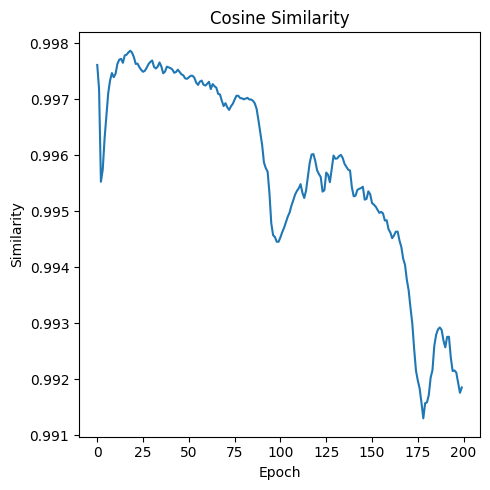

In [ ]:
diffusion_model.fit(ds.dataset, epochs = EPOCHS, callbacks=[model_callback])

In [ ]:
diffusion_model.save('diffusion_model.keras')
# files.download('diffusion_model.keras')

In [ ]:
load_weights = False
if load_weights:
    diffusion_model.load_weights('diffusion_model.keras')

1000it [08:02,  2.07it/s]


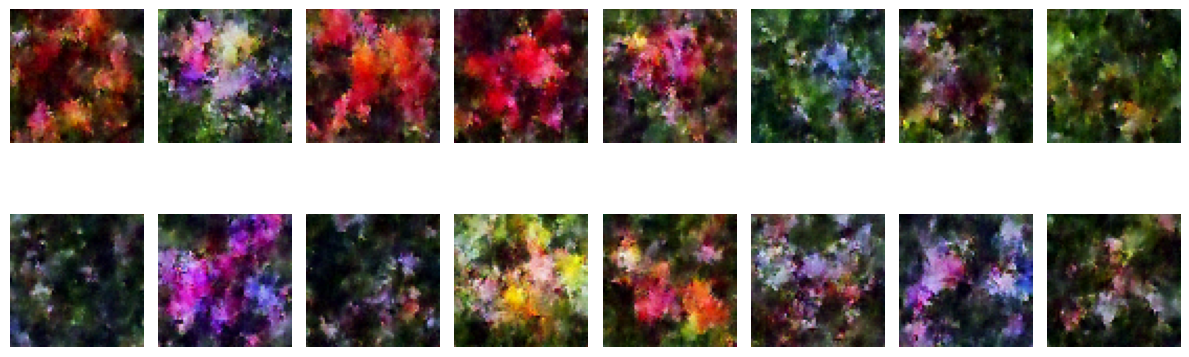

In [ ]:
diffusion_model.plot_images()

1000it [07:55,  2.10it/s]


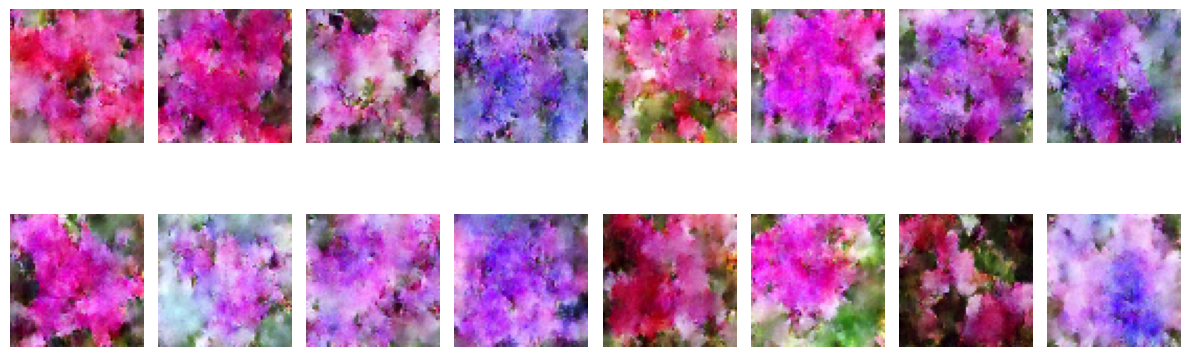

In [ ]:
diffusion_model.plot_images(model='model')

In [ ]:
# from google.colab import runtime
# runtime.unassign()